In [1]:
import os
import pydicom
import matplotlib.pyplot as plt
import numpy as np

import torch
import urllib
import numpy as np
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T

In [2]:
class Conv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Conv, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)
    

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()

        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

    
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, up_sample_mode, last_layer):
        super(UpBlock, self).__init__()

        if up_sample_mode == 'conv_transpose':
            self.up_sample = nn.ConvTranspose2d(in_channels-out_channels, in_channels-out_channels, kernel_size=2, stride=2)        
        elif up_sample_mode == 'bilinear':
            self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            raise ValueError("Unsupported `up_sample_mode` (can take one of `conv_transpose` or `bilinear`)")
        
        self.double_conv_1 = DoubleConv(in_channels, out_channels)
        self.double_conv_2 = DoubleConv(out_channels, out_channels)

        self.last_layer = False

        if last_layer:
            self.last_layer = True

            self.last_layer_conv = nn.Sequential(
                nn.BatchNorm2d(in_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
            )

    def forward(self, down_input, skip_input):
        x = self.up_sample(down_input)
        x = torch.cat([x, skip_input], dim=1)
        if self.last_layer:
            x = self.last_layer_conv(x)
        else:
            x = self.double_conv_1(x)
            x = self.double_conv_2(x)
        return x

    
class RUN_Net(nn.Module):
    def __init__(self, out_channels=1, up_sample_mode='conv_transpose'):
        super(RUN_Net, self).__init__()

        self.up_sample_mode = up_sample_mode
        self.down_sample = nn.MaxPool2d(kernel_size=2)
        # Downsampling Path
        self.down_conv1 = Conv(1, 64)
        self.down_conv2 = DoubleConv(64, 64)
        self.down_conv3_1 = DoubleConv(64, 128)
        self.down_conv3_2 = DoubleConv(128, 128)
        self.down_conv4_1 = DoubleConv(128, 256)
        self.down_conv4_2 = DoubleConv(256, 256)
        # Bottleneck
        self.bottleneck_1 = DoubleConv(256, 512)
        self.bottleneck_2 = DoubleConv(512, 512)
        # Upsampling Path
        self.up_conv4 = UpBlock(256 + 512, 256, self.up_sample_mode, False)
        self.up_conv3 = UpBlock(128 + 256, 128, self.up_sample_mode, False)
        self.up_conv2 = UpBlock(64 + 128, 64, self.up_sample_mode, False)
        self.up_conv1 = UpBlock(64 + 64, 64, self.up_sample_mode, True)
        # Final Convolution
        self.conv_last = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        h = x.shape[0]
        w = x.shape[1]

        x = torch.from_numpy(x)
        x = torch.reshape(x, (1, h, w))
        x = x.type('torch.FloatTensor')
        x = x.unsqueeze(0)
        
        skip1_out = self.down_conv1(x)

        x = self.down_sample(skip1_out)
        skip2_out_1 = self.down_conv2(x)
        # residual blocks
        # skip2_out_1 += x
        skip2_out_2 = self.down_conv2(skip2_out_1)
        # skip2_out_2 += skip2_out_1

        x = self.down_sample(skip2_out_2)
        skip3_out_1 = self.down_conv3_1(x)
        # skip3_out_1 += x
        skip3_out_2 = self.down_conv3_2(skip3_out_1)
        # skip3_out_2 += skip3_out_1

        x = self.down_sample(skip3_out_2)
        skip4_out_1 = self.down_conv4_1(x)
        # skip4_out_1 += x
        skip4_out_2 = self.down_conv4_2(skip4_out_1)
        # skip4_out_2 += skip4_out_1
        
        x = self.down_sample(skip4_out_2)
        skip5_out_1 = self.bottleneck_1(x)
        skip5_out_2 = self.bottleneck_2(skip5_out_1)
        skip5_out_3 = self.bottleneck_2(skip5_out_2)
        skip5_out_4 = self.bottleneck_2(skip5_out_3)

        x = self.up_conv4(skip5_out_4, skip4_out_2)
        x = self.up_conv3(x, skip3_out_2)
        x = self.up_conv2(x, skip2_out_2)
        x = self.up_conv1(x, skip1_out)
        x = self.conv_last(x)

        out = x.squeeze(0)

        return out
    

# Get UNet model
model = RUN_Net()

In [3]:
test_input = np.load('../Data/Brain tumor MRI and CT scan/data(processed)/test_input.npy')
test_output = np.load('../Data/Brain tumor MRI and CT scan/data(processed)/test_output.npy')
train_input = np.load('../Data/Brain tumor MRI and CT scan/data(processed)/train_input.npy')
train_output = np.load('../Data/Brain tumor MRI and CT scan/data(processed)/train_output.npy')
val_input = np.load('../Data/Brain tumor MRI and CT scan/data(processed)/val_input.npy')
val_output = np.load('../Data/Brain tumor MRI and CT scan/data(processed)/val_output.npy')


In [4]:
train_input.shape, train_output.shape, val_input.shape, val_output.shape, test_input.shape, test_output.shape

((570, 256, 256),
 (570, 256, 256),
 (90, 256, 256),
 (90, 256, 256),
 (150, 256, 256),
 (150, 256, 256))

In [5]:
img = test_output[1]

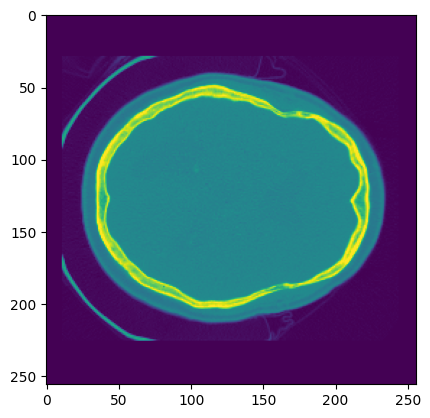

In [19]:
plt.imshow(img)  
plt.show()

In [17]:
out = model(img)
out.shape

torch.Size([1, 256, 256])

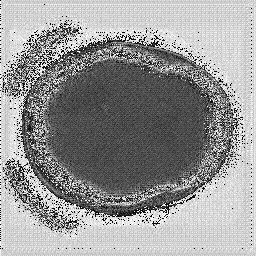

In [18]:
out = T.ToPILImage()(out)
out
